## Prep Equations and Initialization

In [1033]:
function Heavi(t)
    if t>=0.0
        return 1.0
    else
        return 0.0
    end
end

function diracdelta(n;tol=0.001)
    if isapprox(n, 0.0, atol=tol)
        return typeof(n)(1)
    else
        return typeof(n)(0)
    end
end

function nearestto(xvec, x)
    mins = abs.(xvec.-x)
    minval, minidx = findmin(mins)
    minval = xvec[minidx]
    return minval, minidx
end

function prepenvironment(; c=0.1, M=0.3, a=343.3, amp=10.0, shift=10.0, k=0.1)
    v = M*a
    omega = k*2*v/c
    
    function U(t)
        return M*a
    end

    function Udot(t)
        return 0
    end

    function alpha(t)
        alf = shift + amp*sin(omega*t)
        return alf*(pi/180)
    end

    function alphadot(t)  
        alfd = amp*omega*cos(omega*t)
        return alfd*(pi/180)
    end

    function alphaddot(t)
        alfdd = -amp*(omega^2)*sin(omega*t)
        return alfdd*(pi/180)
    end
    
    return U, Udot, alpha, alphadot, alphaddot
end

function ffun2(alpha, alpha1, S)
    if alpha<=alpha1
        return 1.0-0.3*exp((alpha-alpha1)/S[1])
    else
        return 0.04 + 0.66*exp((alpha1-alpha)/S[2]) #One paper has a plus here, another has a minus. 
    end
end

nothing

In [1034]:
using Plots, DifferentialEquations, FLOWMath, DelimitedFiles, Polynomials, Statistics, LaTeXStrings
nothing

## States

In [1035]:
function states!(dx, x, p, t)
    ### Unpack p
    V, Vdot, alpha, alphadot, c, dCndalpha, alpha1, Cn1, Cmo, A, b, S, K, m, T_p, T_f, T_vl, T_v, a = p #Note: I do use Vdot. 

    ### Environmental values
    M = V(t)/a #Mach number
    beta = sqrt(1-(M^2)) #Compressibility factor #TODO: This will need to be updated to handle if someone hands it a mach number greater than 1. 
    q(t) = alphadot(t)*c/V(t) #Pitch rate

    ### Constants
    L = 2*V(t)/c
    tau_p = T_p/L
    tau_f = T_f/L
    tau_vl = T_vl/L
    tau_v = T_v/L

    # println(tau_vl)

    tau_l = c/a #Todo. I need to find out if this should be the definition just after equation 4 in leishman 1990, or on the top right page of 839 of the same paper. This is defined in the nomenclature section. 
    k_alpha = 1/((1-M) + (pi*beta*(M^2)*((A[1]*b[1])+(A[2]*b[2]))))
    k_q = 1/((1-M) + (2*pi*beta*(M^2)*((A[1]*b[1])+(A[2]*b[2]))))
    k_alpha_m = ((A[3]*b[4])+(A[4]*b[3]))/(b[3]*b[4]*(1-M))
    k_q_m = 7/((15*(1-M))+(3*pi*beta*(M^2)*b[5]))

    ### Update the attached flow states (The first four)
    dx[1] = L*(beta^2)*(-b[1]*x[1]) + alpha(t) + q(t)/2 #High frequency shed vortex
    dx[2] = L*(beta^2)*(-b[2]*x[2]) + alpha(t) + q(t)/2 #Low frequency shed vortex
    dx[3] = (-1/(k_alpha*tau_l))*x[3] + alpha(t) #Impulse due to angle of attack
    dx[4] = (-1/(k_q*tau_l))*x[4] + q(t) #Impulse due to pitch rate. 
    dx[5] = (-1/(b[3]*k_alpha_m*tau_l))*x[5] + alpha(t)
    dx[6] = (-1/(b[4]*k_alpha_m*tau_l))*x[6] + alpha(t)
    dx[7] = -b[5]*(beta^2)*L*x[7] + q(t)
    dx[8] = (-1/(k_q_m*tau_l))*x[8] + q(t)

    ### Calculate the attached lift
    Ccn = dCndalpha*L*(beta^2)*((A[1]*b[1]*x[1])+(A[2]*b[2]*x[2])) #Circulatory lift
    Cina = (4/M)*dx[3] #Normal force due to angle of attack #Todo: Should I calculate this before I update dx? 
    Cinq = (1/M)*dx[4] #Normal force due to pitch rate #Todo: Same as above. I can look at the indicial approach to get an idea. 
    Cpn = Ccn + Cina + Cinq #Attached flow lift
    # println("Cpn: ", Cpn)


    ### Calculate the dynamic flow states (the second four)
    dx[9] = (-1/tau_p)*x[9] + (Cpn/tau_p) #Delayed attached lift.
    # println("tau_p: ", tau_p)

    alpha_f = x[9]/dCndalpha #Equivalent angle of attack
    fp = ffun2(alpha_f, alpha1, S./L) #Equivalent separation point #S.*conv(t)
    # println("fp: ", fp)
    # if fp<0
    #     println("")
    #     println("alpha_f: ", alpha_f)
    #     println("fp: ", fp)
    # end
    dx[10] = (-1/tau_f)*x[10] + (fp/tau_f) #Delayed equivalent separation point

    # dx[11] = (V(t)/(2*c))*Heavi(x[9]-Cn1)*Heavi(2*tau_vl - x[11]) - V(t)*Heavi(Cn1-x[5])*Heavi(x[7])/c #Position of the separation point
    # dx[11] = (V(t)/(2*c))*Heavi(x[9]-Cn1)*Heavi(2*tau_vl - x[11]) #I want to try without my diminishing term
    # dx[11] = (V(t)/(3*c))*Heavi(x[9]-Cn1) #I'm not sure that this should cut off when it passes the 2tau value, what if I want a second vortex?
    dx[11] = (2*V(t)/c)*Heavi(x[9]-Cn1) #The dymore has delta t * v/b... which would imply that the 2 is on top, not bottom. 
    # dx[11] = Heavi(x[9]-Cn1)/3 #Dimensional vortex location (seconds) I'm not sure if it makes sense to do this. 
    if x[9]<Cn1 #TODO: This can easily be rewritten as x[11] = x[11]*Heavi(abs(x[9])-Cn1) #Which means that tau will be reset if Cn' is less then Cn1
        x[11]=0
    end
    
    Ccndot = dCndalpha*(2*Vdot(t)/c)*(1-(M^2))*((A[1]*b[1]*x[1])+(A[2]*b[2]*x[2])) + dCndalpha*(2*V(t)/c)*(1-(M^2))*((A[1]*b[1]*dx[1])+(A[2]*b[2]*dx[2])) - dCndalpha*(4*(M^2)/c)*Vdot(t)*((A[1]*b[1]*x[1])+(A[2]*b[2]*x[2])) #Derivative of the circulatory normal force with respect to time. 
    # Cvdot = (Ccndot*(1-((1+sqrt(x[10]))^2)/4) - Ccn*(1 + sqrt(x[10]))*dx[10]/(4*sqrt(x[10])))*Heavi(2*tau_vl - x[11])*Heavi(x[9]-Cn1) #*(c/a) #*(2*V(t)/c) #Derivative of the vortex lift contribution with respect to time. #Todo: There is something going on here. I don't think the units quite work out. I tried correcting the units by multiplying by 2V/c, but that gave me this huge jump. And I don't think there is supposed to be this huge jump. At least, that's what the paper's solutions show. Thus there is something up. I also tried multiplying by c/a... which doesn't help because it makes the forcing function even smaller. 
    # Cvdot = Ccn*(1-(((1+sqrt(x[10]))/2)^2))*Heavi(2*tau_vl - x[11])*Heavi(x[9]-Cn1) #Note: Cvn dropped even more. 
    # Cvdot = (Ccndot*(1-((1+sqrt(x[10]))^2)/4) - Ccn*(1 + sqrt(x[10]))*dx[10]/(4*sqrt(x[10])))*Heavi(2*tau_vl - x[11]) - Ccn*(1-((1+sqrt(x[10]))^2)/4)*dx[11]*diracdelta(2*tau_vl-x[11]) #I'm comparing a united time constant against a unitless state.
    # Cvdot = (Ccndot*(1-((1+sqrt(x[10]))^2)/4) - Ccn*(1 + sqrt(x[10]))*dx[10]/(4*sqrt(x[10])))*Heavi(2*T_vl - x[11]) - Ccn*(1-((1+sqrt(x[10]))^2)/4)*dx[11]*diracdelta(2*T_vl-x[11]) 
    #Comparing against unitless time constants made a huge difference, now the results are in the right direction, but much too huge. I wonder if it's that the rate of tau is too large? 
    # Cvdot = (Ccndot*(1-((1+sqrt(x[10]))^2)/4) - Ccn*(1 + sqrt(x[10]))*dx[10]/(4*sqrt(x[10])))*Heavi(T_vl - x[11]) - Ccn*(1-((1+sqrt(x[10]))^2)/4)*dx[11]*diracdelta(T_vl-x[11]) #That didn't make too big of a change. 
    Cvdot = (Ccndot*(1-((1+sqrt(x[10]))^2)/4) - Ccn*(1 + sqrt(x[10]))*dx[10]/(4*sqrt(x[10])))*Heavi(2*T_vl - x[11])
    # Cvdot = (Ccndot*(1-((1+sqrt(x[10]))^2)/4) - Ccn*(1 + sqrt(x[10]))*dx[10]/(4*sqrt(x[10])))*Heavi(2*tau_vl - x[11])


#     if Cvdot>0.001
#         println(Cvdot)
#     end
    # println("") 
    # println("Ccn: ", Ccn)
    # println("Ccndot: ", Ccndot)
    # println("Cvdot: ", Cvdot)
    # dx[12] = (-1/tau_v)*x[12] + Cvdot/(tau_v) #Vortex lift contribution
    dx[12] = (-1/tau_v)*x[12] + Cvdot/(T_v) #Vortex lift contribution
    # dx[12] = (-1/tau_v)*x[12] + Cvdot/(tau_v*(2*V(t)/c)) #Trying by using a lame way to derive Cv w.r.t nondimensional time. 
    dx[13] = (-2/tau_f)*x[13] + 2*fp/tau_f

end

states! (generic function with 1 method)

## ParseSolution

In [1036]:
function parsesolution2(sol, p; eta=0.95)
    function extractdata(sol)
        t = sol.t
        u = reduce(hcat, sol.u)'
        n,m = size(u)
        du = zeros(n,m)

        for j=1:m
            du[:,j] = gradient(t, u[:,j], t)
        end
        return t, u, du
    end

    V, Vdot, alpha, alphadot, c, dCndalpha, alpha1, Cn1, Cmo, A, b, S, K, m, T_p, T_f, T_vl, T_v, a = p

    t, x, dx = extractdata(sol)

    ### Constants
    L = 2*V(t)/c
    tau_p = T_p/L
    tau_f = T_f/L
    tau_vl = T_vl/L
    tau_v = T_v/L

    n = length(t)

    #Initialize arrays
    Ccn = zeros(n)
    Cina = zeros(n)
    Cinq = zeros(n)
    Cpn = zeros(n)

    alphaE = zeros(n)
    Cfn = zeros(n)
    Cfc = zeros(n)
    Cfm = zeros(n)
    Cvm = zeros(n)

    Cnt = zeros(n)
    Cnt2 = zeros(n)
    Cdt = zeros(n)
    Cmt = zeros(n)

    for i = 1:n
        ### Calculate constants
        M = V(t[i])/a
        beta = sqrt(1-(M^2))

        ### Calculate attached lift
        Ccn[i] = dCndalpha*(2*V(t[i])/c)*(beta^2)*((A[1]*b[1]*x[i,1])+(A[2]*b[2]*x[i,2])) #Circulatory lift
        Cina[i] = (4/M)*dx[i,3] #Normal force due to angle of attack  
        Cinq[i] = (1/M)*dx[i,4] #Normal force due to pitch rate 

        Cpn[i] = Ccn[i] + Cina[i] + Cinq[i] #Attached normal force

        alphaE[i] = (beta^2)*(2*V(t[i])/c)*((A[1]*b[1]*x[i,1])+(A[2]*b[2]*x[i,2])) #Effective angle of attack

        Cfn[i] = dCndalpha*(((1+sqrt(x[i,10]))^2)/4)*alphaE[i] + Cina[i] + Cinq[i] #Nonlinear dynamic normal force
        Cfc[i] = eta*dCndalpha*(alphaE[i]^2)*sqrt(x[i,10]) #Chordwise Force
        Cfm[i] = (K[1] + (K[2]*(1-x[i,13])) + (K[3]*sin(pi*(x[i,13]^m))))*Ccn[i] + Cmo

        # Cpv = (1 - cos(pi*x[i,11]/tau_vl))/4
        Cpv = (1 - cos(pi*x[i,11]/T_vl))/4
        Cvm[i] = -Cpv*x[i,12]

        Cnt[i] = Cfn[i] + x[i,12] #Total dynamic normal force
        Cnt2[i] = (((1+sqrt(x[i,10]))^2)/4)*(dCndalpha*alphaE[i] + Cina[i] + Cinq[i]) + x[i,12] #As above but including the nonlinear forces in the diminished portion of the lift. 
        Cdt[i] = Cnt[i]*sin(alpha(t[i])) - Cfc[i]*cos(alpha(t[i])) #Drag
        Cmt[i] = Cfm[i] + Cvm[i]
    end
    return t, x, dx, Cnt, Cdt, Cmt
end

nothing

## AnalyzeSolution

In [1037]:
function analyzesolution(sol, p; eta=0.95)
    function extractdata(sol)
        t = sol.t
        u = reduce(hcat, sol.u)'
        n,m = size(u)
        du = zeros(n,m)

        for j=1:m
            du[:,j] = gradient(t, u[:,j], t)
        end
        return t, u, du
    end

    V, Vdot, alpha, alphadot, c, dCndalpha, alpha1, Cn1, Cmo, A, b, S, K, m, T_p, T_f, T_vl, T_v, a = p

    t, x, dx = extractdata(sol)

    ### Constants
    L = 2*V(t)/c
    tau_p = T_p/L
    tau_f = T_f/L
    tau_vl = T_vl/L
    tau_v = T_v/L

    n = length(t)

    #Initialize arrays
    Ccn = zeros(n)
    Cina = zeros(n)
    Cinq = zeros(n)
    Cpn = zeros(n)

    Ccndot = zeros(n)
    Cvdot = zeros(n)
    Cv = zeros(n)
    Hcv = zeros(n)

    alphaE = zeros(n)
    Cfn = zeros(n)
    Cfc = zeros(n)
    Cfm = zeros(n)
    Cvm = zeros(n)

    Cnt = zeros(n)
    Cnt2 = zeros(n)
    Cdt = zeros(n)
    Cmt = zeros(n)

    tauflag = true
    tausflag = false
    tvlflag = true
    tstartvec = []
    tstopvec = []
    tvlvec = []

    for i = 1:n
        ### Calculate constants
        M = V(t[i])/a
        beta = sqrt(1-(M^2))

        ### Calculate attached lift
        Ccn[i] = dCndalpha*(2*V(t[i])/c)*(beta^2)*((A[1]*b[1]*x[i,1])+(A[2]*b[2]*x[i,2])) #Circulatory lift
        Cina[i] = (4/M)*dx[i,3] #Normal force due to angle of attack  
        Cinq[i] = (1/M)*dx[i,4] #Normal force due to pitch rate 

        Cpn[i] = Ccn[i] + Cina[i] + Cinq[i] #Attached normal force

        Ccndot[i] = dCndalpha*(2*Vdot(t)/c)*(1-(M^2))*((A[1]*b[1]*x[i,1])+(A[2]*b[2]*x[i,2])) + dCndalpha*(2*V(t)/c)*(1-(M^2))*((A[1]*b[1]*dx[i,1])+(A[2]*b[2]*dx[i,2])) - dCndalpha*(4*(M^2)/c)*Vdot(t)*((A[1]*b[1]*x[i,1])+(A[2]*b[2]*x[i,2])) #Derivative of the circulatory normal force with respect to time. #This matches the numerical derivative of Ccn. 
        # Cvdot = (Ccndot*(1-((1+sqrt(x[10]))^2)/4) - Ccn*(1 + sqrt(x[10]))*dx[10]/(4*sqrt(x[10])))*Heavi(2*tau_vl - x[11])*Heavi(x[9]-Cn1) #*(c/a) #*(2*V(t)/c) #Derivative of the vortex lift contribution with respect to time. #Todo: There is something going on here. I don't think the units quite work out. I tried correcting the units by multiplying by 2V/c, but that gave me this huge jump. And I don't think there is supposed to be this huge jump. At least, that's what the paper's solutions show. Thus there is something up. I also tried multiplying by c/a... which doesn't help because it makes the forcing function even smaller. 
        # Cvdot = Ccn*(1-(((1+sqrt(x[10]))/2)^2))*Heavi(2*tau_vl - x[11])*Heavi(x[9]-Cn1) #Note: Cvn dropped even more. 
        # Cvdot[i] = (Ccndot[i]*(1-((1+sqrt(x[i,10]))^2)/4) - Ccn[i]*(1 + sqrt(x[i,10]))*dx[i,10]/(4*sqrt(x[i,10])))*Heavi(2*tau_vl - x[i,11]) - Ccn[i]*(1-((1+sqrt(x[i,10]))^2)/4)*dx[i,11]*diracdelta(2*tau_vl-x[i,11])
        # Cvdot[i] = (Ccndot[i]*(1-((1+sqrt(x[i,10]))^2)/4) - Ccn[i]*(1 + sqrt(x[i,10]))*dx[i,10]/(4*sqrt(x[i,10])))*Heavi(2*tau_vl - x[i,11])
        Cvdot[i] = (Ccndot[i]*(1-((1+sqrt(x[i,10]))^2)/4) - Ccn[i]*(1 + sqrt(x[i,10]))*dx[i,10]/(4*sqrt(x[i,10])))*Heavi(2*T_vl - x[i,11])

        # Cv[i] = Ccn[i]*(1-((1+sqrt(x[i,10]))^2)/4)*Heavi(2*tau_vl - x[i,11])
        Cv[i] = Ccn[i]*(1-((1+sqrt(x[i,10]))^2)/4)*Heavi(2*T_vl - x[i,11])

        # Hcv[i] = Heavi(2*tau_vl - x[i,11])
        Hcv[i] = Heavi(2*T_vl - x[i,11])

        alphaE[i] = (beta^2)*(2*V(t[i])/c)*((A[1]*b[1]*x[i,1])+(A[2]*b[2]*x[i,2])) #Effective angle of attack

        Cfn[i] = dCndalpha*(((1+sqrt(x[i,10]))^2)/4)*alphaE[i] + Cina[i] + Cinq[i] #Nonlinear dynamic normal force
        Cfc[i] = eta*dCndalpha*(alphaE[i]^2)*sqrt(x[i,10]) #Chordwise Force
        Cfm[i] = (K[1] + (K[2]*(1-x[i,13])) + (K[3]*sin(pi*(x[i,13]^m))))*Ccn[i] + Cmo

        # Cpv = (1 - cos(pi*x[i,11]/tau_vl))/4
        Cpv = (1 - cos(pi*x[i,11]/T_vl))/4
        Cvm[i] = -Cpv*x[i,12]

        Cnt[i] = Cfn[i] + x[i,12] #Total dynamic normal force
        Cnt2[i] = (((1+sqrt(x[i,10]))^2)/4)*(dCndalpha*alphaE[i] + Cina[i] + Cinq[i]) + x[i,12] #As above but including the nonlinear forces in the diminished portion of the lift. 
        Cdt[i] = Cnt[i]*sin(alpha(t[i])) - Cfc[i]*cos(alpha(t[i])) #Drag
        Cmt[i] = Cfm[i] + Cvm[i]

        if x[i,11]>=2*T_vl && tvlflag
            tvlflag = false
            push!(tvlvec, t[i])
        end
        if x[i,11]>0 && tauflag
            tauflag = false
            tausflag = true
            push!(tstartvec, t[i])
        elseif isapprox(x[i,11],0.0, atol=0.0001) && tausflag
            tauflag = true
            tausflag = false
            tvlflag = true
            # println("Got here")
            push!(tstopvec, t[i])
        end
    end
    return Cv, Cvdot, Ccn, Ccndot, tstartvec, tstopvec, tvlvec, Hcv
end

nothing

## Solutions

### Constants

In [1038]:
### Constants
mach = 0.3
a = 343.3
v = mach*a #Putting the speed here to calculate w. 

A = [0.3, 0.7, 1.5, -0.5]
b = [0.14, 0.53, 0.25, 0.1, 0.5] #Todo: Need new values here. 
S = [2.75, 1.4] 
K = [0.0175, -0.12, 0.04]
m = 2.0

T_p = 1.7
T_f = 3.0
T_v = 6.0
T_vl = 7.5
a = 343.3

dCndalpha = 0.113*180/pi
alpha1 = 14.0*(pi/180)
alpha0 = 0.17*(pi/180)
Cn1 = 1.31
Cmo = -0.0037

### Initialize 
u0 = zeros(13)
u0[1] = 0.00
u0[2] = 0.00
u0[3] = 0.00
u0[4] = 5e-6
u0[5] = 0.00
u0[6] = 0.00
u0[7] = 0.00
u0[8] = 0.00
u0[9] = 0.00
u0[10] = 1.00 #Assuming the vortex starts attached
u0[11] = 0.00 #Assuming the vortex starts attached
u0[12] = 0.00
u0[13] = 1.00

tspan = (0.0, 0.5)
nothing

### Solution 1

In [1039]:
kay = 0.10

dtminn = 0.0001
alg = Tsit5()

fvec = [4, 5.33, 6, 8, 10]
kcvec = [0.051, 0.067, 0.076, 0.102, 0.127]

ceevec = zeros(length(fvec))

for i = 1:length(fvec)
    ceevec[i] = kcvec[i]*mach*a/(fvec[i]*pi)
end

cee = round(mean(ceevec); sigdigits=4)

Ufun1, Udotfun1, alphafun1, alphadotfun1, alphaddotfun1 = prepenvironment(; c=cee, M=mach, a=343.3, amp=10.0, shift=5.0, k=kay)

p1 = [Ufun1, Udotfun1, alphafun1, alphadotfun1, cee, dCndalpha, alpha1, Cn1, Cmo, A, b, S, K, m, T_p, T_f, T_vl, T_v, a]

prob1 = ODEProblem(states!, u0, tspan, p1)
sol1 = solve(prob1, alg; dtmin=dtminn, force_dtmin=true) #;dtmax=0.0001 solve(prob)

t1, u1, du1, Cnt1, Cdt1, Cmt1 = parsesolution2(sol1, p1; eta=0.97)

alphavec1 = alphafun1.(t1)
alfavec1 = alphavec1.*(180/pi)

println("Run Information: ")
println("Chord Length: ", cee)
println("")

nothing

Run Information: 
Chord Length: 0.4159



In [1040]:
polar = readdlm("/Users/adamcardoza/Box/research/FLOW/bladeopt/experimentaldata/Leishman1989/leishman1989staticdata_fig1.csv", ',')
polar[:,1] = polar[:,1].*(pi/180) #Convert to radians

attachedlift = readdlm("/Users/adamcardoza/Box/research/FLOW/bladeopt/experimentaldata/leishman1989statespace/fig8/naca0012/leishman1989 fig 8 lift naca0012.csv", ',')
mal = readdlm("/Users/adamcardoza/Box/research/FLOW/bladeopt/experimentaldata/leishman1989statespace/fig8/naca0012/leishman1989 fig 8 naca 0012 lift model.csv", ',')

attacheddrag = readdlm("/Users/adamcardoza/Box/research/FLOW/bladeopt/experimentaldata/leishman1989statespace/fig8/naca0012/Fig8_drag_exp.csv", ',')
mad = readdlm("/Users/adamcardoza/Box/research/FLOW/bladeopt/experimentaldata/leishman1989statespace/fig8/naca0012/fig8_drag_model.csv", ',')

attachedmnt = readdlm("/Users/adamcardoza/Box/research/FLOW/bladeopt/experimentaldata/leishman1989statespace/fig8/naca0012/fig8_moment_exp.csv", ',')
mam = readdlm("/Users/adamcardoza/Box/research/FLOW/bladeopt/experimentaldata/leishman1989statespace/fig8/naca0012/fig8_moment_model.csv", ',')

using FLOWMath

liftfit = Akima(polar[:,1], polar[:,2])

Csn1 = liftfit.(alphavec1)

nothing

In [1041]:
using FLOWMath

cv, cvdot, ccn, ccndot, tstartvec, tstopvec, tvlvec, Hcv = analyzesolution(sol1, p1; eta=0.97)

ccndot2 = gradient(t1, ccn, t1)
cvdot2 = gradient(t1, cv, t1)

nothing

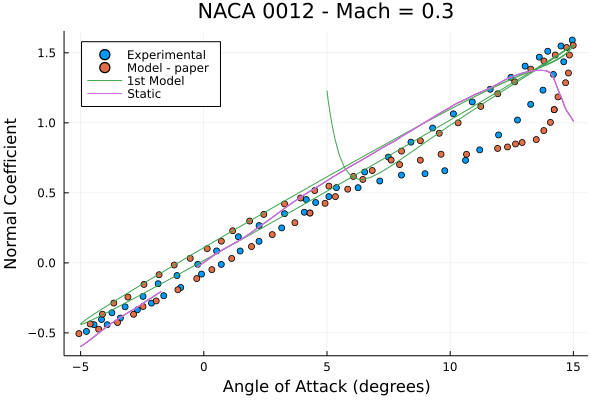

In [1042]:
cyclepltattached = plot(legend=:topleft, xaxis="Angle of Attack (degrees)", yaxis="Normal Coefficient", title="NACA 0012 - Mach = $mach")
scatter!(attachedlift[:,1], attachedlift[:,2], lab="Experimental")
scatter!(mal[:,1], mal[:,2], lab="Model - paper")
plot!(alfavec1, Cnt1, lab="1st Model")
plot!(alfavec1, Csn1, lab="Static")
display(cyclepltattached)
# savefig("/Users/adamcardoza/Box/research/FLOW/bladeopt/figures/dynamicstall/comparison/compareblmodels_naca0012_10.0a_10.0s09162021_attachedflow.png")

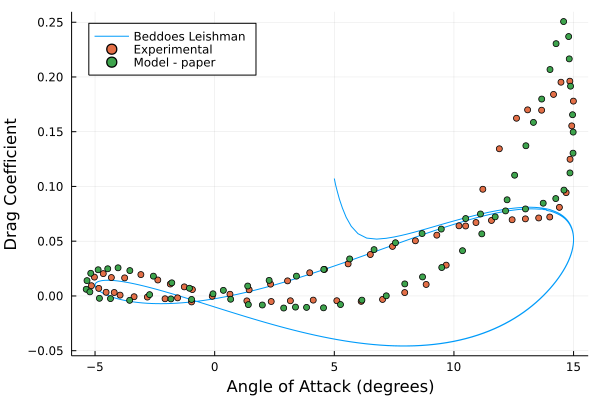

In [1043]:
dragplt = plot(;legend=:topleft, xaxis="Angle of Attack (degrees)", yaxis="Drag Coefficient")
plot!(alfavec1, Cdt1, label="Beddoes Leishman")
scatter!(attacheddrag[:,1], attacheddrag[:,2], lab="Experimental")
scatter!(mad[:,1], mad[:,2], lab="Model - paper")
display(dragplt)

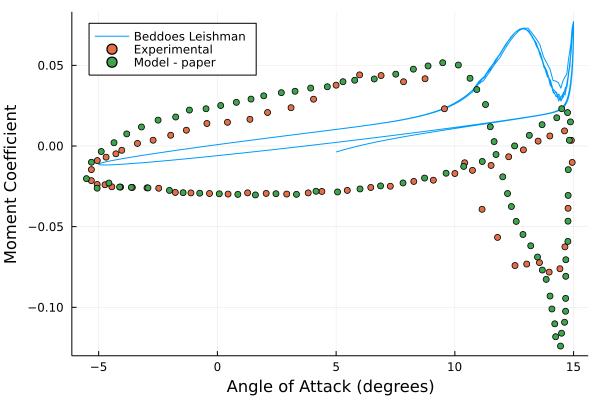

In [1044]:
momentplt = plot(;legend=:topleft, xaxis="Angle of Attack (degrees)", yaxis="Moment Coefficient")
plot!(alfavec1, Cmt1, label="Beddoes Leishman")
scatter!(attachedmnt[:,1], attachedmnt[:,2], lab="Experimental")
scatter!(mam[:,1], mam[:,2], lab="Model - paper")
display(momentplt)

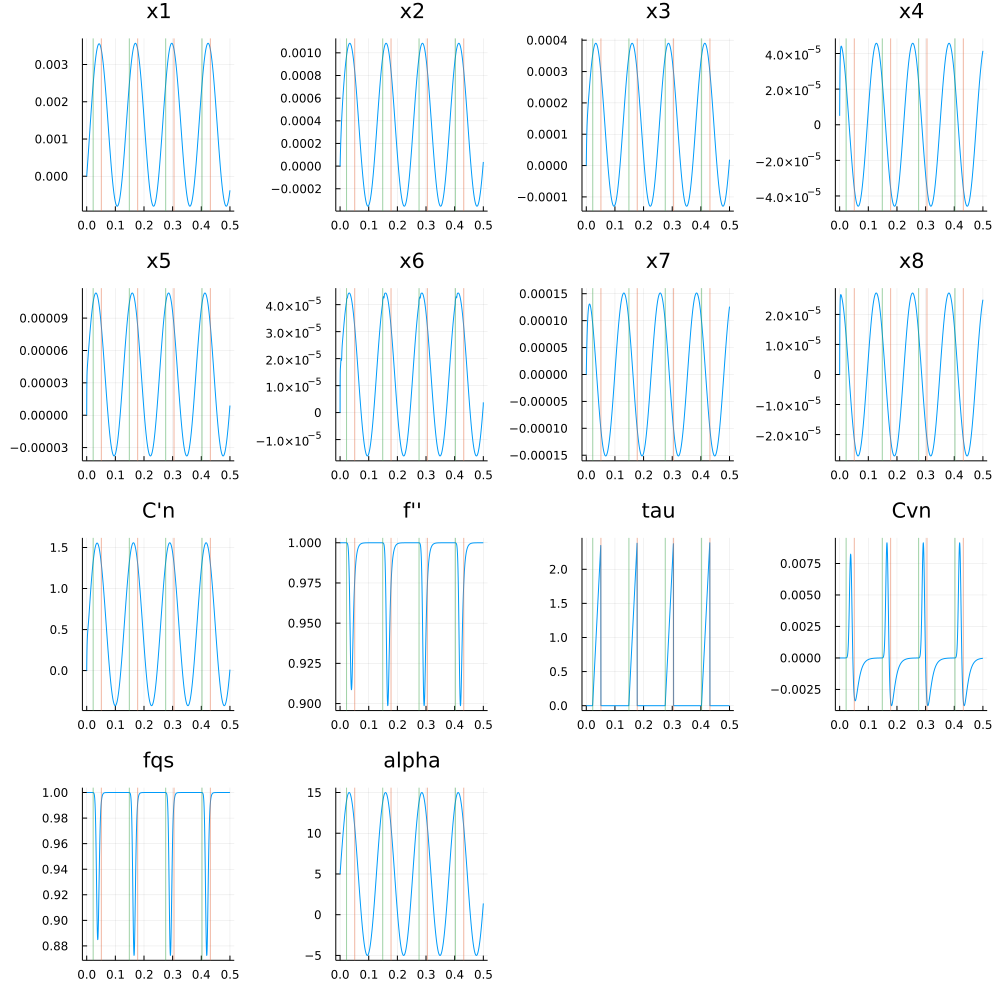

In [1045]:
mat1 = hcat(u1, alfavec1)
plt1 = plot(t1, mat1[:,1], title="x1")
vline!(tstopvec, la=0.5)
vline!(tstartvec, la=0.5)
plt2 = plot(t1, mat1[:,2], title="x2")
vline!(tstopvec, la=0.5)
vline!(tstartvec, la=0.5)
plt3 = plot(t1, mat1[:,3], title="x3")
vline!(tstopvec, la=0.5)
vline!(tstartvec, la=0.5)
plt4 = plot(t1, mat1[:,4], title="x4")
vline!(tstopvec, la=0.5)
vline!(tstartvec, la=0.5)
plt5 = plot(t1, mat1[:,5], title="x5")
vline!(tstopvec, la=0.5)
vline!(tstartvec, la=0.5)
plt6 = plot(t1, mat1[:,6], title="x6")
vline!(tstopvec, la=0.5)
vline!(tstartvec, la=0.5)
plt7 = plot(t1, mat1[:,7], title="x7")
vline!(tstopvec, la=0.5)
vline!(tstartvec, la=0.5)
plt8 = plot(t1, mat1[:,8], title="x8")
vline!(tstopvec, la=0.5)
vline!(tstartvec, la=0.5)
plt9 = plot(t1, mat1[:,9], title="C\'n")
vline!(tstopvec, la=0.5)
vline!(tstartvec, la=0.5)
plt10 = plot(t1, mat1[:,10], title="f\'\'")
vline!(tstopvec, la=0.5)
vline!(tstartvec, la=0.5)
plt11 = plot(t1, mat1[:,11], title="tau")
vline!(tstopvec, la=0.5)
vline!(tstartvec, la=0.5)
plt12 = plot(t1, mat1[:,12], title="Cvn")
vline!(tstopvec, la=0.5)
vline!(tstartvec, la=0.5)
plt13 = plot(t1, mat1[:,13], title="fqs")
vline!(tstopvec, la=0.5)
vline!(tstartvec, la=0.5)
plt14 = plot(t1, mat1[:,14], title="alpha")
vline!(tstopvec, la=0.5)
vline!(tstartvec, la=0.5)
plot(plt1, plt2, plt3, plt4, plt5, plt6, plt7, plt8, plt9, plt10, plt11, plt12, plt13, plt14, layout=14, leg=false, size=(1000,1000))

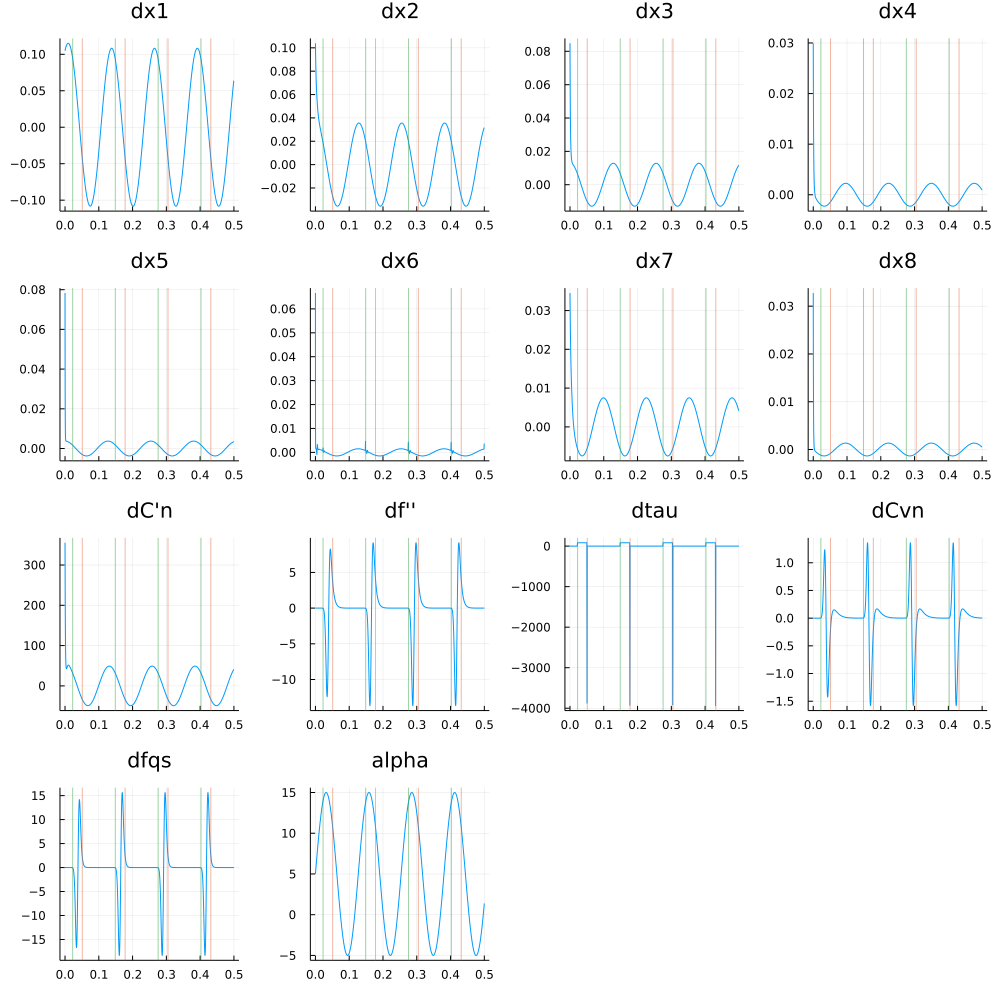

In [1046]:
mat2 = hcat(du1, alfavec1)
pltd1 = plot(t1, mat2[:,1], title="dx1")
vline!(tstopvec, la=0.5)
vline!(tstartvec, la=0.5)
pltd2 = plot(t1, mat2[:,2], title="dx2")
vline!(tstopvec, la=0.5)
vline!(tstartvec, la=0.5)
pltd3 = plot(t1, mat2[:,3], title="dx3")
vline!(tstopvec, la=0.5)
vline!(tstartvec, la=0.5)
pltd4 = plot(t1, mat2[:,4], title="dx4")
vline!(tstopvec, la=0.5)
vline!(tstartvec, la=0.5)
pltd5 = plot(t1, mat2[:,5], title="dx5")
vline!(tstopvec, la=0.5)
vline!(tstartvec, la=0.5)
pltd6 = plot(t1, mat2[:,6], title="dx6")
vline!(tstopvec, la=0.5)
vline!(tstartvec, la=0.5)
pltd7 = plot(t1, mat2[:,7], title="dx7")
vline!(tstopvec, la=0.5)
vline!(tstartvec, la=0.5)
pltd8 = plot(t1, mat2[:,8], title="dx8")
vline!(tstopvec, la=0.5)
vline!(tstartvec, la=0.5)
pltd9 = plot(t1, mat2[:,9], title="dC\'n")
vline!(tstopvec, la=0.5)
vline!(tstartvec, la=0.5)
pltd10 = plot(t1, mat2[:,10], title="df\'\'")
vline!(tstopvec, la=0.5)
vline!(tstartvec, la=0.5)
pltd11 = plot(t1, mat2[:,11], title="dtau")
vline!(tstopvec, la=0.5)
vline!(tstartvec, la=0.5)
pltd12 = plot(t1, mat2[:,12], title="dCvn")
vline!(tstopvec, la=0.5)
vline!(tstartvec, la=0.5)
pltd13 = plot(t1, mat2[:,13], title="dfqs")
vline!(tstopvec, la=0.5)
vline!(tstartvec, la=0.5)
pltd14 = plot(t1, mat2[:,14], title="alpha")
vline!(tstopvec, la=0.5)
vline!(tstartvec, la=0.5)
plot(pltd1, pltd2, pltd3, pltd4, pltd5, pltd6, pltd7, pltd8, pltd9, pltd10, pltd11, pltd12, pltd13, pltd14, layout=14, leg=false, size=(1000,1000))

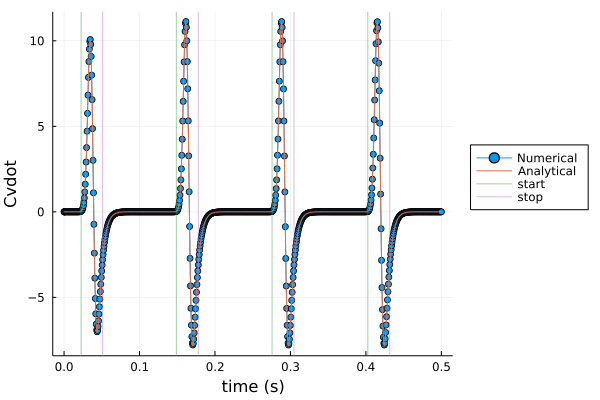

In [1047]:
cvdotplt = plot(legend=:outerright,xaxis="time (s)", yaxis="Cvdot")
plot!(t1, cvdot2, lab="Numerical",markershape=:circle)
plot!(t1, cvdot, lab="Analytical")
vline!(tstartvec, la=0.5, lab="start")
vline!(tstopvec, la=0.5, lab="stop")
display(cvdotplt)
# savefig("/Users/adamcardoza/Box/research/FLOW/bladeopt/figures/dynamicstall/comparison/cvderivatives.png")

There is evidently some sort of difference. It appears that when the little uptick on the analytical appears, we get this massive uptick on the numerical. This could be to a mismatched dt, I suppose, or something like that, but I'm not entirely sure. 

Makes me think that I should plot $C_v$

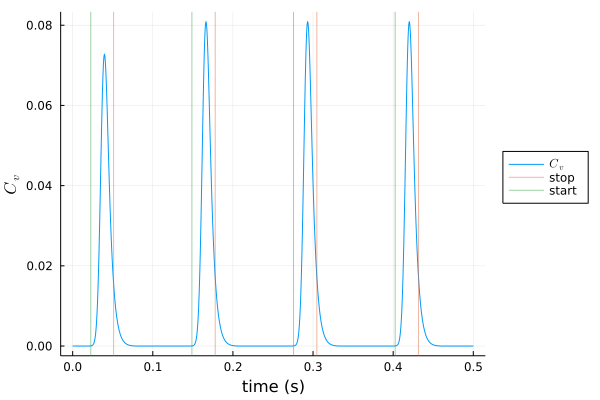

In [1055]:
cvplt = plot(;legend=:outerright, xaxis="time (s)", yaxis=L"C_v")
plot!(t1, cv, lab=L"C_v")
vline!(tstopvec, la=0.5, lab="stop")
vline!(tstartvec, la=0.5, lab="start")
# vline!(tvlvec, la=0.5, lab=L"2T_{vl}")
display(cvplt)
# savefig("/Users/adamcardoza/Box/research/FLOW/bladeopt/figures/dynamicstall/comparison/cvplot.png")

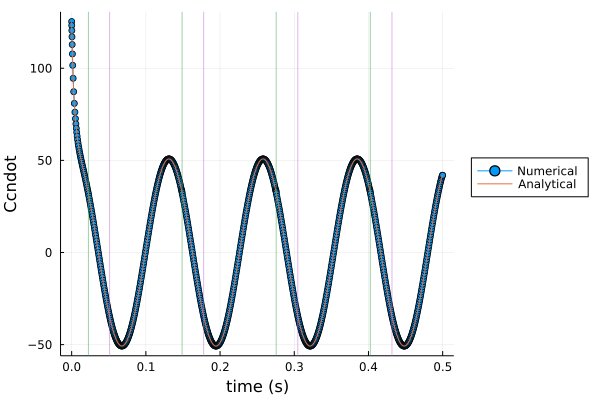

In [1049]:
ccndotplt = plot(legend=:outerright,xaxis="time (s)", yaxis="Ccndot")
plot!(t1, ccndot2, lab="Numerical",markershape=:circle)
plot!(t1, ccndot, lab="Analytical")
vline!(tstartvec, la=0.5, lab=false)
vline!(tstopvec, la=0.5, lab=false)
display(ccndotplt)
# savefig("/Users/adamcardoza/Box/research/FLOW/bladeopt/figures/dynamicstall/comparison/ccnderivatives.png")

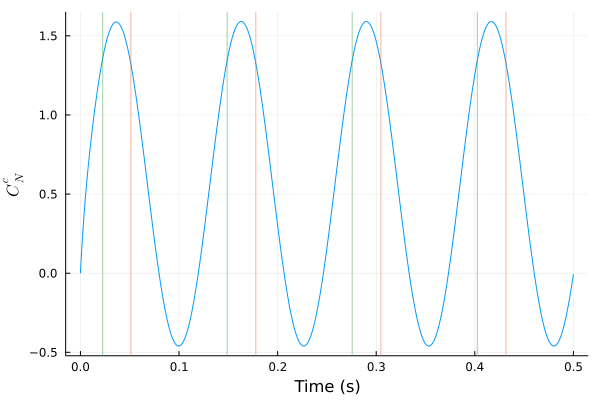

In [1050]:
Ccnplt = plot(legend=:false, xaxis="Time (s)", yaxis=L"C^c_N")
plot!(t1, ccn)
vline!(tstopvec, la=0.5, lab=false)
vline!(tstartvec, la=0.5, lab=false)
display(Ccnplt)

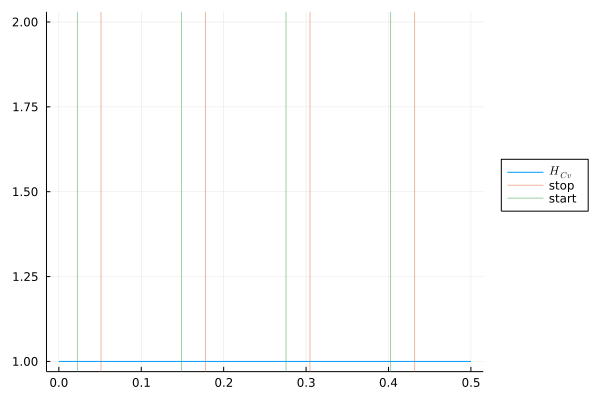

In [1051]:
hplt = plot(leg=:outerright)
plot!(t1, Hcv, lab=L"H_{Cv}")
vline!(tstopvec, la=0.5, lab="stop")
vline!(tstartvec, la=0.5, lab="start")
display(hplt)

In [1052]:
tvlvec


Any[]

In [1053]:
tstartvec

4-element Vector{Any}:
 0.022582721003629038
 0.14880397331846099
 0.2756415725456167
 0.4025255843525069